In [1]:
from aerobot.dataset import dataset_load
from aerobot.plot import *
# from aerobot.utils import print_taxonomy_info
from aerobot.io import load_results_dict, RESULTS_PATH, DATA_PATH
import numpy as np 
import os
from matplotlib.gridspec import GridSpec
import pandas as pd 
import subprocess
from typing import Dict

%load_ext autoreload
%autoreload 2

plot_configure_mpl(figure_height=2)


In [2]:
# "Minimal list" of feature types.
FEATURE_TYPES = ['KO', 'embedding.geneset.oxygen', 'embedding.genome', 'chemical', 'aa_1mer', 'aa_3mer']

In [3]:
# Load in the phylogenetic cross-validation results for the specified feature types. 
phylo_cv_results = {feature_type:load_results_dict(os.path.join(RESULTS_PATH, f'phylo_cv_nonlinear_{feature_type}_ternary.json')) for feature_type in FEATURE_TYPES}
taxonomy_coverage_df = pd.read_csv(os.path.join(DATA_PATH, 'earth_microbiome', 'taxonomy_coverage.csv'))

# SI Figure 4

In [4]:
def plot_si_figure_4a(taxonomy_coverage_df:pd.DataFrame, fig:plt.Figure=None, grid:GridSpec=None):

    # Make the easiest plot, which just shows percent coverage by phylogenetic level. 
    ax = fig.add_subplot(grid)
    n = len(taxonomy_coverage_df) # Number of habitats.
    levels = ['Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'][::-1] 
    
    human_color, color = plot_color_palette()['red'], plot_color_palette()['blue']
    colors = [color if not is_human else human_color for is_human in taxonomy_coverage_df.habitat.str.contains('human')]
    for i, level in enumerate(levels):
        ax.scatter(np.array([i] * n), taxonomy_coverage_df[level].values, linewidth=0.5, edgecolors='white', facecolors=colors, s=20)# , edgecolors=edgecolors)

    x_vals, y_vals = [], []
    for i, level in enumerate(levels): # Make sure these are plotted on top.
        x_vals.append(i)
        y_vals.append(taxonomy_coverage_df[level].mean())

    ax.plot(x_vals, y_vals, c=color, alpha=0.5)
    ax.scatter(x_vals, y_vals, c=plot_color_palette()['darkblue'], s=20, edgecolor='white', linewidth=0.5)

    # Custom legend. Colors indicate annotation-free or annotation-full, and hatching indicates training or validation set. 
    handles = [plt.Rectangle((0, 0), 1, 1, facecolor=human_color, edgecolor='black', linewidth=0.5)]
    handles.append(plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', linewidth=0.5))
    handles.append(plt.Rectangle((0, 0), 1, 1, facecolor='black', edgecolor='black', linewidth=0.5))

    labels = ['human habitats', 'non-human habitats', 'mean']
    ax.legend(handles, labels, loc='lower right')

    ax.set_xticks(np.arange(len(levels)), labels=levels, rotation=45)
    ax.set_ylabel('coverage of EMP samples')
    ax.set_xlabel('phylogenetic level')
    ax.set_title('Phylogenetic label coverage in the EMP')

    return ax

In [5]:
def plot_si_figure_4b(phylo_cv_results:Dict, fig:plt.Figure=None, grid:GridSpec=None):
    '''Phylogenetic cross-validation results for the minimal list of feature types.'''
    ax = fig.add_subplot(grid)
    plot_phylo_cv(phylo_cv_results, ax=ax, legend=True, color=None)
    ax.set_title('Phylogenetic cross-validation on nonlinear models')

    return ax
    

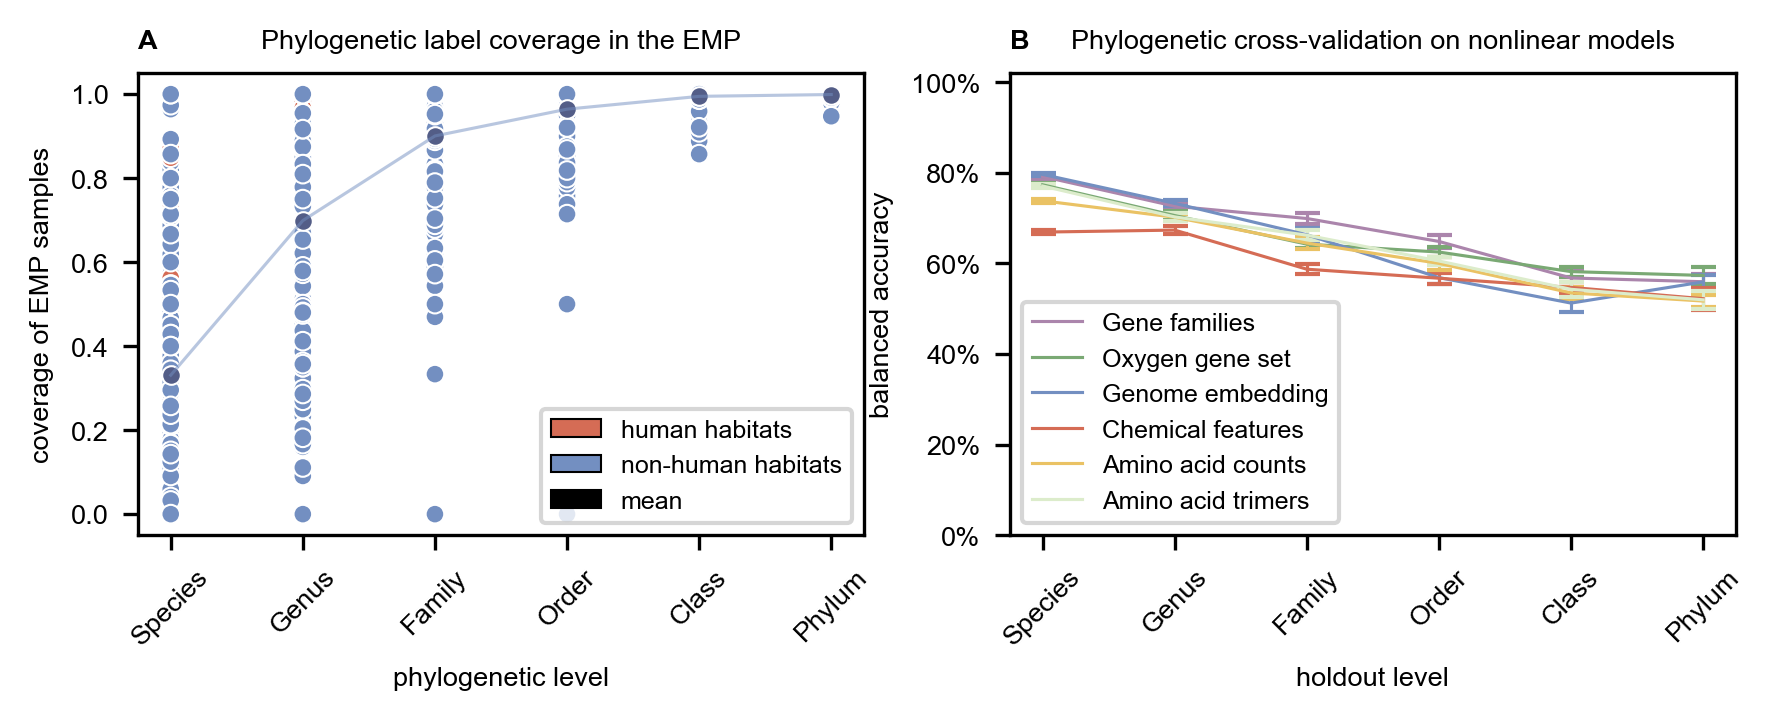

In [6]:
fig = plt.figure()
grid = GridSpec(1, 2, wspace=0.2, hspace=0.3)

axes = []
axes.append(plot_si_figure_4a(taxonomy_coverage_df, grid=grid[0, 0], fig=fig))
axes.append(plot_si_figure_4b(phylo_cv_results, grid=grid[0, 1], fig=fig))

for ax, ax_label in zip(axes, 'AB'):
    ax.set_title(ax_label, loc='left', fontweight='bold')

plt.savefig('../results/figures/si_fig4.png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()